Standard imports. May take a few seconds.

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy as sp

import pymc3 as pm
import theano
import theano.tensor as tt
import tensorflow as tf

from collections import OrderedDict
from warnings import filterwarnings

"Bayes by Backprop" Bayesian Neural Network using Variational Inference
===
Now we construct a simple one layer bayesian network using ADVI for approximate inference in PyMC3 to classify the Fashion-MNIST images. Then, we look at performance metrics and use the inherently probabilistic nature of this model to look at performance variance. We also loosely compare to a similarly designed traditional neural network made with SGD using tensorflow via Keras. 

In [2]:
# Print environment for consistency
print('Environment: ', sys.executable)
# Print versions
print('PyMC3  v{} | Theano v{} | Tensorflow v{}'.format(pm.__version__,theano.__version__,tf.__version__))
# Fix plotting
mpl.rcdefaults()
%matplotlib inline
# Set random seeds
np.random.seed(999)
pm.set_tt_rng(999)
# Avoid warnings on batches below
filterwarnings('ignore')

Environment:  /Users/stephenholtz/anaconda3/envs/bbb_models/bin/python
PyMC3  v3.5 | Theano v1.0.3 | Tensorflow v1.10.0


## Import the dataset 

First we will use keras to load in the Fashion-MNIST data, and preprocess it for easy use. Note we avoid making the `X_train`, `X_test` etc. into a theano shared variable here so that we can use it for our tensorflow network as well.

In [16]:
# Load and process images
def load_fashionMNIST():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train = X_train.astype(theano.config.floatX,copy=True).reshape(X_train.shape[0],-1)/255
    X_test = X_test.astype(theano.config.floatX,copy=True).reshape(X_test.shape[0],-1)/255
    y_train, y_test = y_train.astype(np.int), y_test.astype(np.int)
    return (X_train,y_train),(X_test,y_test)

(X_train, y_train), (X_test, y_test) = load_fashionMNIST()

# All the Fashion-MNIST labels
label_dict = OrderedDict({0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
                          3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
                          7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'})


imgvec2img = lambda vec : vec.reshape(np.sqrt(vec.shape[0]).astype(int),-1)

The data are similar to MNIST in size, but instead have shirts, shoes etc., Below we look a random subset of them.

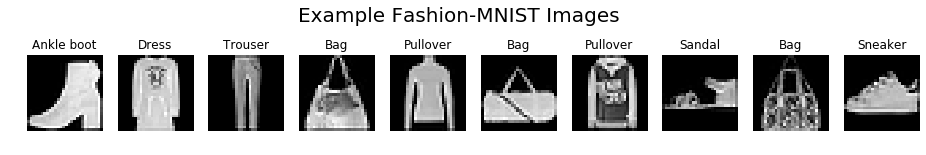

In [17]:
# Plot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_train_plot.shape[0],size=n_plot_samples,replace=False)

figsize = (16,2.5); fontsize = 16;
f, axs = plt.subplots(1,n_plot_samples,sharex=True,figsize=figsize);
for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    ax.axis('off')
    ax.set_title(label_dict[y_train_plot[rs]]);
    sns.despine();
f.suptitle("Example Fashion-MNIST Images",fontsize=fontsize+4);

## Make and Train a Single Hidden Layer Network Backprop with SGD
First, for comparison purposes we will use tensorflow (via keras) to make a network with the same architecture as our soon to be implemented bayesian neural network (below) for qualitative comparison purposes. Note this will not exactly be a fair fight, but we do train similar amounts.

In [18]:
# We selected number of nodes in the hidden layer for fast performance
n_hidden = 96
n_output = len(label_dict)

# make more convenient categorical variables for keras
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=n_output)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=n_output)

In [19]:
def make_1layer_tf_network(n_input,n_output):
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Input

    ann_input = Input(shape=(n_input,))
    x = Dense(n_hidden, activation='tanh')(ann_input)
    x = Dense(n_output, activation='softmax')(x)
    return Model(ann_input,x)

In [20]:
tf_model = make_1layer_tf_network(np.prod(X_train.shape[1:]),len(label_dict))
tf_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy']);
tf_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                75360     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                970       
Total params: 76,330
Trainable params: 76,330
Non-trainable params: 0
_________________________________________________________________


In [21]:
tf_model.fit(X_train, y_train_onehot, epochs=5, batch_size=50, verbose=1);

Epoch 1/5
60000/60000 [==============================] - 2s 25us/step - loss: 0.8231 - acc: 0.7376
Epoch 2/5
60000/60000 [==============================] - 1s 22us/step - loss: 0.5532 - acc: 0.8166
Epoch 3/5
60000/60000 [==============================] - 1s 23us/step - loss: 0.4980 - acc: 0.8307
Epoch 4/5
60000/60000 [==============================] - 1s 22us/step - loss: 0.4697 - acc: 0.8374
Epoch 5/5
60000/60000 [==============================] - 1s 22us/step - loss: 0.4505 - acc: 0.8430


In [24]:
#tf.keras.utils.to_categorical(y_train)
tf_train_preds = tf_model.predict(X_train, batch_size=50)
tf_test_preds = tf_model.predict(X_test, batch_size=50)

tf_train_loss, tf_train_acc = tf_model.evaluate(X_train, y_train_onehot)
tf_test_loss, tf_test_acc = tf_model.evaluate(X_test, y_test_onehot)

print("SGD Network Accuracy\nTrain: {:f} Test: {:f}".format(tf_train_acc,tf_test_acc))

10000/10000 [==============================] - 0s 12us/step
SGD Network Accuracy
Train: 0.845217 Test: 0.831000


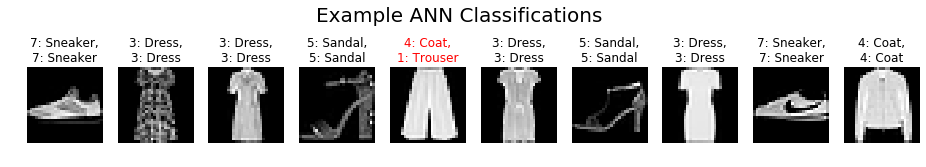

In [39]:
# Plot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (16,2.5); fontsize = 16;
f, axs = plt.subplots(1, n_plot_samples, figsize=figsize);

for i,(rs,ax) in enumerate(zip(rand_samps,axs.T)):
    pred = np.argmax(tf_test_preds[rs])
    real = y_test[rs]
    # Show image and classifications
    ax.imshow(imgvec2img(X_test[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(pred,label_dict[pred],
                                  real,label_dict[real])
    if pred == real:
        ax.set_title(tl,color='k');
    else:
        ax.set_title(tl,color='r');
    ax.axis('off');
    
f.suptitle("Example ANN Classifications",fontsize=fontsize+4,y=1.05);

## Build and fit the BBB model
We construct a single layer bayesian neural network with all weights using a composite normal distribution as in the Bayes by BackProp paper. Weighting between two gaussians is controlled by `pi` and was selected roughly to be able to see model convergence and to achieve reasonable model performance. Note this is not critical for convergence, but may help raise the ceiling on classification accuracy. 

In [40]:
def make_1layer_bbb_network(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64, use_bias=True):
     # initial weights, standard normal here and scaled below to match prior distributions
    init_w_in_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_b_1 = np.random.randn(n_hidden_1).astype(theano.config.floatX)
    init_w_1_out = np.random.randn(n_hidden_1, n_output).astype(theano.config.floatX)
    
    pi  = 0.95 # weighting between normals
    sda = 1.75 # sd for first normal
    sdb = 0.25 # sd for second normal
    
    with pm.Model() as neural_network:
        # Weights from input to first hidden layer
        w_in_1a = pm.Normal('w_in_1a', mu=0, sd=sda, shape=(n_input, n_hidden_1),testval=init_w_in_1*sda)
        w_in_1b = pm.Normal('w_in_1b', mu=0, sd=sdb, shape=(n_input, n_hidden_1),testval=init_w_in_1*sdb)
        w_in_1 = pm.Deterministic('w_in_1',pi*w_in_1a+(1-pi)*w_in_1b)
        # Bias in first layer        
        if use_bias:
            b_1a = pm.Normal('b_1a',mu=0, sd=sda, shape=(n_hidden_1),testval=init_b_1*sda)
            b_1b = pm.Normal('b_1b',mu=0, sd=sdb, shape=(n_hidden_1),testval=init_b_1*sdb)
            b_1 = pm.Deterministic('b_1',pi*b_1a+(1-pi)*b_1b)
        else:
            b_1 = 0
        
        # Weights from 1st hidden layer to output layer
        w_1_outa = pm.Normal('w_1_outa',mu=0, sd=sda, shape=(n_hidden_1, n_output),testval=init_w_1_out*sda)
        w_1_outb = pm.Normal('w_1_outb',mu=0, sd=sdb, shape=(n_hidden_1, n_output),testval=init_w_1_out*sdb)
        w_1_out = pm.Deterministic('w_1_out',pi*w_1_outa+(1-pi)*w_1_outb)
        
        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_in_1)+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
        
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

In [41]:
# Minibatches speed up training substaintally
shared_x = pm.Minibatch(X_train, batch_size=100)
shared_y = pm.Minibatch(y_train, batch_size=100)

pm_model = make_1layer_bbb_network(shared_x, shared_y, 
                                   n_input=X_train.shape[1], 
                                   n_output=len(label_dict), 
                                   n_train=X_train.shape[0], 
                                   n_hidden_1=n_hidden,use_bias=True)

We will use ADVI for approximate inference. It has two parameters $\mu$ and $\rho$ just as in the Bayes by Backprop paper.

In [42]:
with pm_model:
    advi = pm.ADVI()
print(advi.approx.shared_params)

{'mu': mu, 'rho': rho}


Now we will configure the `tracker` to keep track of parameter mean and std. The API doesn't grant more granularity over tracking without more work, so we will just use these to see that parameters are moving after initialization. We choose a conservative number of iterations because later we can run more iterations using `advi.refine()` after inspecting the ELBO plot.

In [43]:
# To better look at convergence, we keep track of parameter mean and std,
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
tracker = pm.callbacks.Tracker(mean = advi.approx.mean.eval, # callable that returns mean
                               std = advi.approx.std.eval)   # callable that returns std
n_approx_iter = 20000
with pm_model:
    # NOTE: callbacks do not work for large numbers of iters larger networks (>40k)
    approx = advi.fit(n=n_approx_iter, callbacks=[tracker])

Average Loss = 481.66: 100%|██████████| 20000/20000 [08:28<00:00, 39.30it/s]
Finished [100%]: Average Loss = 481.4


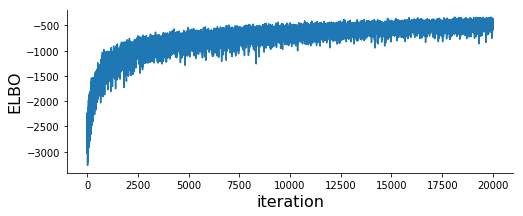

In [44]:
# plot the training progress
figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(-advi.hist,label='1');
ax.set_ylabel('ELBO',fontsize=fontsize);
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

Now we look at the means of the parameters and standard deviations of those parameters over iterations. Since there is some structure in the trends with which parameters change, we take a random subset (`randset`, below) of them to look at diversity. Extracting these parameters is very time consuming, so we opt to subsample them on an empirically determined scale.

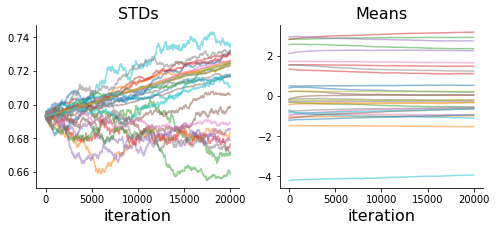

In [45]:
subsamp_fac = 20

# remap the list of arrays into arrays at a particular index, most efficient way I could think of
iter_array = np.arange(advi.state.i)[::subsamp_fac]
get_weight_mean = lambda i : [tracker['mean'][int(j)][i] for j in iter_array]
get_weight_stds = lambda i : [tracker['std'][int(j)][i] for j in iter_array]

figsize = (8,3); fontsize = 16;
f, axs = plt.subplots(1,2,figsize=figsize)

randset = np.random.choice(len(tracker['mean']),30)

ax = axs[0]
for i in randset:
    ax.plot(iter_array,get_weight_stds(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
ax.set_title('STDs',fontsize=fontsize);
sns.despine();

ax = axs[1]
for i in randset:
    ax.plot(iter_array,get_weight_mean(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
ax.set_title('Means',fontsize=fontsize);
sns.despine();

## Test the BBB Model Performance

In [46]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 1000 # > 2k draws hangs for almost all network sizes on a 2018 MBP
trace = approx.sample(draws=n_draws)

To get performance on the training and test data we construct another two networks `pm_model_perf_train` and `pm_model_perf_test` to sample the posterior predictive distribution, using the trace (posterior samples) from the ADVI approximation above. And for speed's sake we just take a subset of the training data to test the model with (size equal to the training data since it is a more manageable size.

In [47]:
n_ppc_samps = 100

# Make performance testing model
shared_x = theano.shared(X_train[:X_test.shape[0]])
shared_y = theano.shared(y_train[:y_test.shape[0]])
pm_model_perf_train = make_1layer_bbb_network(shared_x, shared_y, 
                                   n_input=X_train.shape[1], 
                                   n_output=len(label_dict), 
                                   n_train=y_test.shape[0], 
                                   n_hidden_1=n_hidden)
# Sample posterior predictive for training data subset
with pm_model_perf_train:
    #ppc_train = pm.sample_posterior_predictive(trace, samples=100)
    ppc_train = pm.sample_ppc(trace, samples=n_ppc_samps) # deprecated!

# Now do the same for held out test set
shared_x = theano.shared(X_test)
shared_y = theano.shared(y_test)
pm_model_perf_test = make_1layer_bbb_network(shared_x, shared_y, 
                                   n_input=X_test.shape[1], 
                                   n_output=len(label_dict), 
                                   n_train=X_test.shape[0], 
                                   n_hidden_1=n_hidden)
with pm_model_perf_test:
    ppc_test = pm.sample_ppc(trace, samples=n_ppc_samps) # deprecated!

100%|██████████| 100/100 [00:44<00:00,  2.17it/s]


In [48]:
# Prediction is mode of each
y_pred_train = sp.stats.mode(ppc_train['out'], axis=0).mode[0,:]
y_pred_test = sp.stats.mode(ppc_test['out'], axis=0).mode[0,:]

mean_train_acc = np.mean(y_pred_train==y_train[:y_test.shape[0]])
mean_test_acc = np.mean(y_pred_test==y_test)

print("BBB Model Accuracy:\n  Train {:f}\n  Test  {:f}".format(mean_train_acc,mean_test_acc))

BBB Model Accuracy:
  Train 0.818400
  Test  0.802900


Plotting the classification that are made very often "make sense" given the similarity of shapes or ambiguity of label. But! We can go one step further and see how confident the network was in each of these individual classifications since we have samples. Here we will look at a histogram of the categorizations for each example image across our `n_ppc_samps` samples. The correct category will be indicated in the histogram as a black or red bar at perfect accuracy, for correct and incorrect modal distributions respectively.

In [49]:
# make more convenient categorical variables
ppc_test_onehot = tf.keras.utils.to_categorical(ppc_test['out'],num_classes=len(label_dict))
ppc_test_hist = np.sum(ppc_test_onehot,axis=0)
ppc_test_pred = np.argmax(ppc_test_hist,axis=1) # identical to using mode above

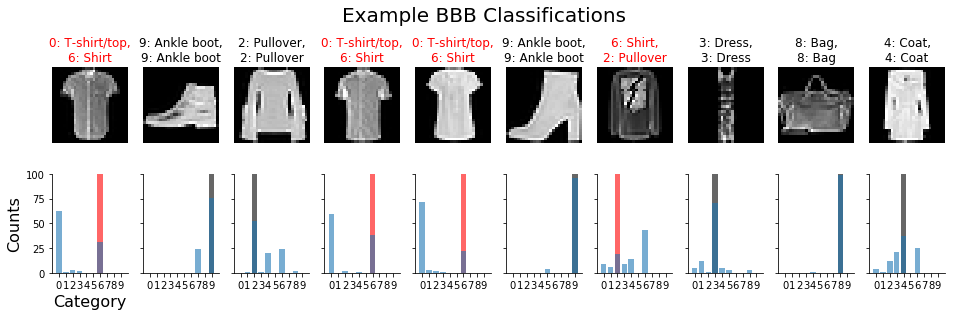

In [50]:
# Plot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (16,4); fontsize = 16;
f, axs = plt.subplots(2, n_plot_samples, figsize=figsize);

for i,(rs,ax) in enumerate(zip(rand_samps,axs.T)):
    pred = ppc_test_pred[rs]
    real = y_test[rs]
    # Show image and classifications
    ax[0].imshow(imgvec2img(X_test[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(pred,label_dict[pred],
                                  real,label_dict[real])
    if y_pred_test[rs] == y_test[rs]:
        ax[0].set_title(tl,color='k');
    else:
        ax[0].set_title(tl,color='r');
    ax[0].axis('off');
    #sns.despine();
    
    # Show the classifications as a histogram
    onehot = tf.keras.utils.to_categorical(ppc_test['out'].T[rs],num_classes=len(label_dict))
    if y_pred_test[rs] == y_test[rs]:
        ax[1].bar(real,n_ppc_samps,alpha=0.6,color='k')
    else:
        ax[1].bar(real,n_ppc_samps,alpha=0.6,color='r')
    ax[1].bar(np.arange(len(label_dict)),ppc_test_hist[rs],alpha=0.6)

    ax[1].set_ylim(bottom=0,top=n_ppc_samps)
    ax[1].set_xlim(left=-1,right=10)
    ax[1].set_xticks(np.arange(10))
    if i > 0:
        ax[1].set_yticklabels([])
    else:
        ax[1].set_ylabel("Counts",fontsize=fontsize)
        ax[1].set_xlabel("Category",fontsize=fontsize)
    sns.despine();

f.suptitle("Example BBB Classifications",fontsize=fontsize+4,y=1.05);

Let's break things down by category and look at some performance metrics. Namely, 
 - Fraction of correct predictions by class and confusion matrix,
 - KL divergence from the categorical prior to the empirical classification in each class

The fraction of correct predictions  we  calculate by looking at in vs out of class, so we will throw out any structure in the errors and simply look at if it was right vs wrong. In the confusion matrix we will see if there are classes that are often confused. The KL divergence will tell us the distance between naive performance and actual performance. If looked at in conjunction with accuracy this entropy measure will be a nice way to look at the categorical performance. So we want low standard deviations for all classes, and a high KL divergence between uniform and empirical categorical classification (assuming high accuracy).

In [ ]:
def get_cat_entropy(ppc_X_test_onehot, y_test):
    # get other parameters that need
    (n_test,n_output,n_input) = ppc_X_test_onehot.shape
    
    # make histograms 
    y_test_dist = np.histogram(y_test, bins=n_output)[0]
    cat_hist = np.zeros((n_output, n_output))
    cat_entropy = np.zeros(n_output)
    cat_KL = np.zeros(n_output)
    histograms = np.sum(one_hot, axis=0)
    for i in range(n_output):
        cat_hist[i,:] = np.sum(histograms[y_test == i], axis=0)
        cat_entropy[i] = sp.stats.entropy(cat_hist[i,:])
        cat_KL[i] = sp.stats.entropy(y_test_dist, cat_hist[i,:])
    return one_hot, cat_hist, cat_entropy, cat_KL

In [ ]:
one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test)
plt.imshow(cat_hist)
plt.show()
plt.plot(cat_entropy, label='entropy')
plt.plot(cat_KL, label='KL')
plt.legend()
plt.xlabel('category label')
plt.show()

Again though we can go further and use the probablistic nature of the model to look at uncertainty (STD on prediction) by class. We can also do this by image to find the most "confusing" test images.

Now we can look at the confusion matricies for each of the models. 